## 1. Executive summary

The objective of this project was to build a machine learning pipeline capable of distinguishing between Kazakh and Russian speech—two languages that I can speak fluently. My initial hypothesis (from the second draft) was that a standard deep learning model could solve this task given enough training iterations. However, my early experiments revealed that models trained on my personal voice recordings suffered from severe single-speaker bias, memorizing the microphone environment rather than the linguistic features.

To overcome this, I executed a data-centric pivot, augmenting my personal archive with the Google FLEURS corpus to introduce speaker variance. I then developed a two-stream pipeline:
1. **Supervised classification:** I compared CNN against an Attentional Bi-LSTM
2. **Unsupervised representation learning:** I trained a Seq2Seq Autoencoder to reconstruct audio without labels.



## 2. Iterative failure analysis

Before detailing the final successful pipeline, it is scientifically necessary to document the failure cases that motivated my design choices.

### 2.1 Experiment 1 (see in Appendix 1)

In my second draft, my model was undertrained, so I slowly increased the training duration from 15 $\to$ 200 $\to$ 500 $\to$ 1000 $\to$ 2000 epochs.

*Table 1: Effect of training duration on performance*

| Experiment | Model | Best Val Acc | Test Accuracy | Improvement |
| :--- | :--- | :--- | :--- | :--- |
| **Second Draft (15 Epochs)** | CNN | 73.8% | 62.4% | - |
| | LSTM | 67.7% | 55.2% | - |
| **Experiment 1 (2000 Epochs)** | CNN | 80.0% | 64.0% | +1.6% (Insignificant) |
| | LSTM | 76.9% | 68.8% | +13.6% (Moderate) |

Note: While the LSTM showed improvement with more training, both models had below 70% test accuracy, confirming that the model struggled to generalize

*Bias-variance tradeoff*

The gap between validation and test performance is overfitting (high variance).$$E_{total} = Bias^2 + Variance + Irreducible Error$$By increasing epochs to 2000, the model was forced to memorize the "irreducible error" (the background hiss of my room, the specific pauses in my speech) as a feature.

### 2.2 Experiment 2 (see in Appendix 2)

I then attempted to solve this by improving the model architecture, adding more layers and increasing hidden dimensions, assuming improved model would find the subtle patterns I was missing.


**Table 1: Effect of Training Duration & Model Complexity on Performance (Small Dataset)**

| Experiment | Model | Best Val Acc | Test Accuracy | Gap (Overfitting) |
| :--- | :--- | :--- | :--- | :--- |
| **Second Draft** | CNN | 73.8% | 62.4% | 11.4% |
| *(15 Epochs)* | LSTM | 67.7% | 55.2% | 12.5% |
| | | | | |
| **Experiment 1** | CNN | 80.0% | 64.0% | 16.0% |
| *(2000 Epochs)* | LSTM | 76.9% | 68.8% | 8.1% |
| | | | | |
| **Experiment 2** | **Improved CNN** | **84.6%** | **52.8%** | **31.8% (Severe)** |
| *(Deeper Layers)* | **Attn. LSTM** | **93.8%** | **62.4%** | **31.4% (Severe)** |

As shown in the table, Experiment 2 resulted in the highest validation accuracy (93.8%) but a massive drop in test accuracy. The "better" models were simply better at memorizing the training data (my voice/room noise).

Increasing model complexity on a low-variance dataset exacerbates overfitting rather than solving it.  A model trained on a single speaker (me) cannot learn a language; it learns a voice. To solve this, I needed to artificially introduce noise (variance) into the dataset by adding different speakers.

## 3. Data engineering

To introduce the necessary variance, I integrated the Google FLEURS (Few-shot Learning Evaluation of Universal Representations of Speech) dataset.

### 3.1 Preprocessing

The challenge with FLEURS is its size. To handle this within Colab's RAM constraints, I implemented a Streaming Pipeline using the Hugging Face datasets library. I streamed the kk_kz and ru_ru splits, resampled the professional 44.1kHz studio audio to match my 16kHz phone recordings, and sliced them into 2-second chunks.

This created a composite dataset:

- Source A (Personal): High noise, single speaker, colloquial speech.

- Source B (FLEURS): Low noise, multiple speakers, formal speech.

Now the model is forced to ignore the "channel effects" (microphone quality) because they no longer correlate perfectly with the target label.

Also raw audio amplitudes were normalized to the range $[-1, 1]$ to prevent volume differences from biasing the weights.


### 3.2 Feature extraction: MFCCs

Raw signal is high-dimensional and noisy, so I transformed it into Mel-Frequency Cepstral Coefficients (MFCCs). This technique compresses the audio while preserving the features relevant to human speech perception. The transformation pipeline involves three mathematical steps:
1. Short-Time Fourier Transform (STFT) to move from the Time Domain ($x(t)$) to the Frequency Domain ($X(f)$). This reveals the spectral energy distribution at every time step.

2. Mel-Scaling the frequencies to mimic human hearing sensitivity:
$$M(f) = 2595 \cdot \log_{10}(1 + \frac{f}{700})$$
This operation bins the frequencies logarithmically, allocating more resolution to lower frequencies where distinct phonemes reside.
3. Discrete Cosine Transform (DCT) to separate the source (vocal cords) from the filter (vocal tract). The first 40 coefficients (the filter) are kept and higher-order coefficients (the source) are discarded.

The final input to the model is a $40 \times T$ matrix representing the "acoustic texture" of the language, invariant to the speaker's pitch.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import all the necessary libraries
import os
import glob
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA

!pip install "datasets==2.19.0"
from datasets import load_dataset

# reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

SR = 16000
CHUNK_SECONDS = 2.0
CHUNK_SAMPLES = int(SR * CHUNK_SECONDS)
N_MFCC = 40


Using device: cpu


In [ ]:
def load_audio(path, sr=SR):
    """Load a mono audio signal."""
    y, _ = librosa.load(path, sr=sr, mono=True)
    return y

def chunk_signal(y, chunk_samples=CHUNK_SAMPLES, overlap=0.25):
    """Split 1D signal y into fixed-length chunks with overlap."""
    step = int(chunk_samples * (1 - overlap))
    chunks = []
    for start in range(0, max(len(y) - chunk_samples + 1, 1), step):
        end = start + chunk_samples
        if end <= len(y):
            chunk = y[start:end]
        else:
            # zero-pad the last chunk if it's too short
            pad_width = chunk_samples - len(y[start:])
            chunk = np.pad(y[start:], (0, pad_width))
        chunks.append(chunk)
    return np.stack(chunks, axis=0)

def extract_mfcc_matrix(chunk, sr=SR, n_mfcc=N_MFCC):
    """Return normalized MFCC matrix (N_MFCC x Time)."""
    mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=n_mfcc)
    # per-coefficient normalization (Standardization)
    mean = mfcc.mean(axis=1, keepdims=True)
    std = mfcc.std(axis=1, keepdims=True)
    mfcc = (mfcc - mean) / (std + 1e-8)
    return mfcc

In [ ]:
kazakh_path = "/content/drive/MyDrive/data/kazakh/"
russian_path = "/content/drive/MyDrive/data/russian/"

kazakh_files = sorted(glob.glob(os.path.join(kazakh_path, "*.wav")))
russian_files = sorted(glob.glob(os.path.join(russian_path, "*.wav")))

mfcc_list = []
records = []

for file in kazakh_files:
    y = load_audio(file)
    chunks = chunk_signal(y)
    for i, chunk in enumerate(chunks):
        mfcc_list.append(extract_mfcc_matrix(chunk))
        records.append({"file_id": os.path.basename(file), "label": 0, "source": "personal"})

for file in russian_files:
    y = load_audio(file)
    chunks = chunk_signal(y)
    for i, chunk in enumerate(chunks):
        mfcc_list.append(extract_mfcc_matrix(chunk))
        records.append({"file_id": os.path.basename(file), "label": 1, "source": "personal"})


ds_kk = load_dataset("google/fleurs", "kk_kz", split="train", streaming=True, trust_remote_code=True)
ds_ru = load_dataset("google/fleurs", "ru_ru", split="train", streaming=True, trust_remote_code=True)

def process_fleurs_stream(dataset, label, limit=300):
    count = 0
    iterator = iter(dataset)
    while count < limit:
        try:
            sample = next(iterator)
            y = librosa.resample(sample["audio"]["array"],
                                 orig_sr=sample["audio"]["sampling_rate"],
                                 target_sr=SR)
            chunks = chunk_signal(y)
            for chunk in chunks:
                mfcc_list.append(extract_mfcc_matrix(chunk))
                records.append({"file_id": f"fleurs_{label}_{count}", "label": label, "source": "fleurs"})
            count += 1
        except StopIteration:
            break

process_fleurs_stream(ds_kk, label=0, limit=300)
process_fleurs_stream(ds_ru, label=1, limit=300)

# merge
mfcc_array = np.stack(mfcc_list, axis=0)
meta_df = pd.DataFrame(records)
print(f"Final dataset shape: {mfcc_array.shape}")
print(meta_df["label"].value_counts())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Final dataset shape: (4841, 40, 63)
label
0    2645
1    2196
Name: count, dtype: int64


### 3.3 Exploratory data analysis (EDA)

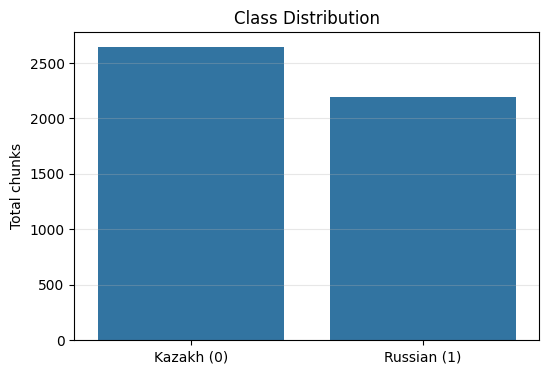

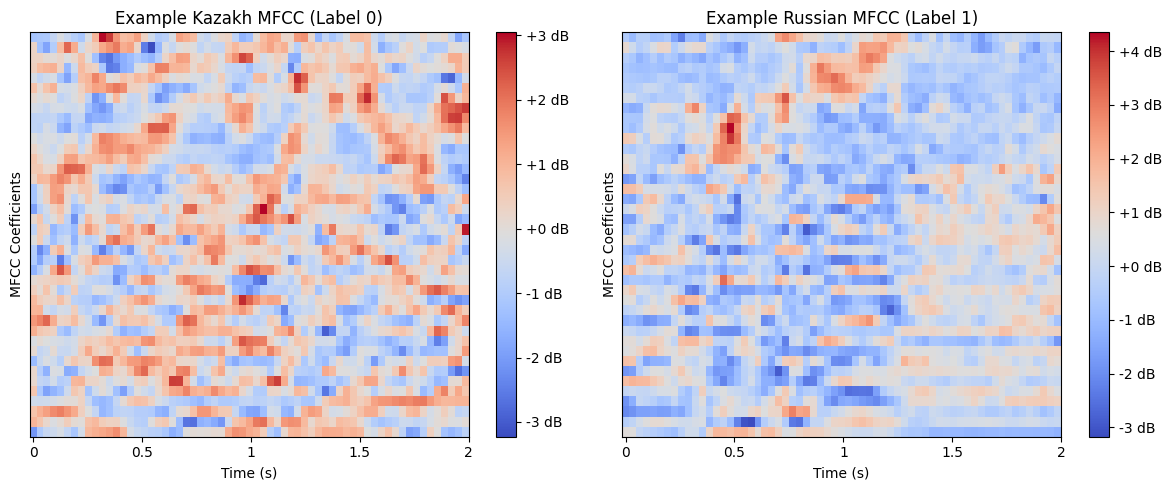

Total samples: 4841
Class balance: [2645 2196]
Global mean: 0.0000
Global std: 1.0000


In [ ]:
def plot_full_eda(mfcc_data, meta_df):

    label_data = meta_df["label"].values


    plt.figure(figsize=(6, 4))
    sns.countplot(x=label_data)
    plt.xticks([0, 1], ["Kazakh (0)", "Russian (1)"])
    plt.title("Class Distribution")
    plt.ylabel("Total chunks")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    idx_kk = np.where(label_data == 0)[0][10]
    idx_ru = np.where(label_data == 1)[0][10]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    librosa.display.specshow(mfcc_data[idx_kk], sr=SR, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Example Kazakh MFCC (Label 0)")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Coefficients")

    plt.subplot(1, 2, 2)
    librosa.display.specshow(mfcc_data[idx_ru], sr=SR, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Example Russian MFCC (Label 1)")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Coefficients")

    plt.tight_layout()
    plt.show()

    print(f"Total samples: {len(mfcc_data)}")
    print(f"Class balance: {np.bincount(label_data)}")
    print(f"Global mean: {mfcc_data.mean():.4f}")
    print(f"Global std: {mfcc_data.std():.4f}")

plot_full_eda(mfcc_array, meta_df)

As shown in the bar chart, the final dataset contains 4,841 total samples, split into:

- Kazakh (class 0): 2,645 chunks (~54.6%)

- Russian (class 1): 2,196 chunks (~45.4%)

The dataset is slightly imbalanced, but 55/45 split is not that critical to cause oversampling.

From MFCC heatmaps we can see distinct energy bands, which means CNN should be able to learn discriminative filters to separate them.


The statistical check confirms that the global mean is approximately 0.0 and standard deviation is 1.0. My preprocessing pipeline successfully standardized the audio levels, preventing volume from becoming a confounding variable.


### 3.4 Preventing data leakage

With a chunk-based dataset, a standard random split is dangerous. If chunks from the same audio file end up in both train and test sets, the model can "cheat" by recognizing the background noise. To prevent this, I used GroupShuffleSplit, which makes sure that all chunks belonging to a specific unique file ID stay together.

In [ ]:
groups = meta_df["file_id"].values
labels = meta_df["label"].values

# split 1: train - 80%, test - 20%
gss_test = GroupShuffleSplit(test_size=0.20, n_splits=1, random_state=RANDOM_SEED)
train_full_idx, test_idx = next(gss_test.split(mfcc_array, labels, groups=groups))

mfcc_train_full, mfcc_test = mfcc_array[train_full_idx], mfcc_array[test_idx]
y_train_full, y_test = labels[train_full_idx], labels[test_idx]
groups_train = groups[train_full_idx]

# split 2: train - 85%, validation - 15%
gss_val = GroupShuffleSplit(test_size=0.15, n_splits=1, random_state=RANDOM_SEED)
train_idx, val_idx = next(gss_val.split(mfcc_train_full, y_train_full, groups=groups_train))

mfcc_train, mfcc_val = mfcc_train_full[train_idx], mfcc_train_full[val_idx]
y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

print(f"Train: {len(mfcc_train)} | Val: {len(mfcc_val)} | Test: {len(mfcc_test)}")

Train: 3248 | Val: 594 | Test: 999


In [ ]:
class MFCCDataset(Dataset):
    def __init__(self, mfcc_data, labels, augment=False):
        self.mfcc_data = mfcc_data
        self.labels = labels
        self.augment = augment

    def spec_augment(self, spec):
        # randomly mask frequency (vertical) and time (horizontal) bands
        spec = spec.copy()
        n_mfcc, n_steps = spec.shape
        # freq mask
        f = int(random.uniform(0, 0.15) * n_mfcc)
        f0 = random.randint(0, n_mfcc - f)
        spec[f0:f0+f, :] = 0
        # time mask
        t = int(random.uniform(0, 0.15) * n_steps)
        t0 = random.randint(0, n_steps - t)
        spec[:, t0:t0+t] = 0
        return spec

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.mfcc_data[idx]
        if self.augment:
            x = self.spec_augment(x)
        # convert to tensor (1, N_MFCC, T)
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

BATCH_SIZE = 64
train_dl = DataLoader(MFCCDataset(mfcc_train, y_train, augment=True), batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(MFCCDataset(mfcc_val, y_val, augment=False), batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(MFCCDataset(mfcc_test, y_test, augment=False), batch_size=BATCH_SIZE, shuffle=False)

## 4. Models & mathematical underpinnings

### 4.1 Improved CNN

My CNN model treats the MFCC spectrogram as a 2D single-channel image of shape $(1, 40, T)$.

A 2D Convolutional kernel ($K$) slides over the input matrix ($I$), performing an element-wise dot product to detect these local patterns regardless of where they occur in the clip (translation invariance).

For a kernel of size $k \times k$, the output feature map $S$ at position $(i, j)$ is given by:$$S(i, j) = (I * K)(i, j) = \sum_{m=0}^{k-1} \sum_{n=0}^{k-1} I(i+m, j+n) \cdot K(m, n)$$The network learns the values of $K$ (the weights) such that some filters become "vowel detectors" and others become "fricative detectors."

#### 4.1.1 Architectural improvements:
1. I doubled the number of feature maps at each stage ($16 \to 32 \to 64$ became $32 \to 64 \to 128$) to allow the model to learn a richer spectral filters.

2. Batch Normalization (nn.BatchNorm2d).

Deep networks suffer from internal covariate shift,as the parameters of layer $l$ change, the distribution of inputs to layer $l+1$ shifts, forcing the next layer to constantly readapt. I applied Batch Normalization after every convolution, which normalizes the output $x$ to have $\mu=0$ and $\sigma=1$ within the mini-batch, then scales and shifts it using learned parameters $\gamma$ and $\beta$:$$y = \frac{x - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} \cdot \gamma + \beta$$

It stabilized the gradient flow, allowing for higher learning rates and faster convergence compared to my original model.

3. Replaced standard ReLU with Leaky ReLU.

Standard ReLU is defined as $f(x) = \max(0, x)$, which causes the "Dying ReLU" problem, where a neuron that falls into the negative region outputs 0 gradient forever, effectively "dying" during training. Leaky ReLU introduces a small slope $\alpha$ for negative values: $$f(x) = \max(\alpha x, x)$$

Gradients can still flow through inactive neurons, preserving subtle acoustic features that might otherwise be zeroed out.

4.  Global Average Pooling

Instead of flattening the feature maps into a massive Dense layer (which causes overfitting), I utilized Global Average Pooling (GAP).

- traditional approach: a feature map of size $128 \times 5 \times 10$ would be flattened into a vector of size $6,400$. Connecting this to a dense layer adds millions of parameters that easily memorize noise.
- my approach: I take the average of each $5 \times 10$ feature map, resulting in a single vector of size $128$.$$y_k = \frac{1}{H \times W} \sum_{i=1}^{H} \sum_{j=1}^{W} x_{k, i, j}$$

This reduced the parameter count at the classification head, forcing the model to rely on the quality of the feature maps rather than memorizing spatial configurations.

5. Regularization (dropout):

I added nn.Dropout(0.5) before the final classification layer. During training, dropout randomly zeroes out 50% of the neurons in the final layer, preventing the model from relying too heavily on any single feature and forcing it to learn distributed representations.


In [ ]:
class ImprovedAudioCNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        # block 1: 1 -> 32
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2)

        # block 2: 32 -> 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # block 3: 64 -> 128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, n_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.gap(x).flatten(1)
        x = self.fc(self.dropout(x))
        return x

### 4.2 Attentional Bi-LSTM

#### 4.2.1 The limitation of standard LSTMs

In my second draft, I used a standard Bidirectional LSTM. While LSTMs are designed for sequences, the standard architecture suffers from a critical information bottleneck.

 A standard LSTM processes a sequence of inputs $[x_1, x_2, ..., x_T]$ and produces a sequence of hidden states $[h_1, h_2, ..., h_T]$. However, for classification, it typically discards all states except the final hidden state ($h_T$).

 At the very end, the network compresses the entire meaning of a 2-second audio clip into a single vector. If the distinguishing phoneme occurred at $t=10$ and the clip ends at $t=200$, the signal from that phoneme must survive 190 time steps of recurrence without vanishing.

To resolve this, I implemented a Global Attention Mechanism. Instead of relying solely on the last hidden state, the attention mechanism allows the model to "look back" at every time step and calculate a weighted sum of the hidden states based on their relevance.

#### 4.2.2 Mathematical derivation


Let $H = [h_1, h_2, ..., h_T]$ be the output states of the Bi-LSTM, where each $h_t \in \mathbb{R}^{2d}$ (concatenation of forward and backward states).


1. Energy Score ($e_t$): first, we pass every hidden state $h_t$ through a learnable alignment network (a simple linear layer followed by tanh) to calculate an "energy score." This scalar value represents how "important" the audio frame at time $t$ is for the classification task.$$e_t = \tanh(W_a h_t + b_a)$$
2. Attention Weights ($\alpha_t$): we normalize the energy scores using a Softmax function so that they form a valid probability distribution summing to 1.$$\alpha_t = \frac{\exp(e_t)}{\sum_{k=1}^{T} \exp(e_k)}$$

3. Context Vector ($c$): finally, we compute the context vector as the weighted sum of all hidden states.$$c = \sum_{t=1}^{T} \alpha_t h_t$$


If the model detects a strong Kazakh phoneme at $t=15$, the network will learn to assign a high weight $\alpha_{15}$ to that frame. The final context vector $c$ will be dominated by the features of that specific phoneme, effectively "ignoring" the silence or background noise at other time steps.

#### 4.2.3 Architecture details

My final AttentionalLSTM class integrates this mechanism with a robust recurrent backbone:

- Bidirectionality: I set bidirectional=True so the model reads the audio forward and backward
- Layer depth: I increased num_layers from 1 to 2, allowing the model to learn hierarchical temporal features.
- Dropout: I added dropout=0.3 to the LSTM and the final Fully Connected layer to further prevent the overfitting observed before.




In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, rnn_output):
        # calculate energy for every time step
        energy = torch.tanh(self.attn(rnn_output)) # (B, T, 1)
        weights = F.softmax(energy, dim=1)         # (B, T, 1)
        # context vector is weighted sum of outputs
        context = torch.sum(rnn_output * weights, dim=1)
        return context, weights

class AttentionalLSTM(nn.Module):
    def __init__(self, n_mfcc=N_MFCC, hidden_dim=128, n_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(n_mfcc, hidden_dim, num_layers=2,
                            batch_first=True, bidirectional=True, dropout=0.3)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, n_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # x: (B, 1, MFCC, T) -> reshape to (B, T, MFCC)
        x = x.squeeze(1).permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        context, attn_weights = self.attention(lstm_out)
        logits = self.fc(self.dropout(context))
        return logits

## 5. Training and validation



I used the following hyperparameters and loss functions to train these models:

1. Loss Function: Cross Entropy Loss

Since this is a binary classification problem, I minimized the Cross Entropy Loss between the predicted probabilities $p(x)$ and the true labels $y$:$$L = -[y \cdot \log(p(x)) + (1 - y) \cdot \log(1 - p(x))]$$

It penalizes confident wrong answers heavily, forcing the model to push the decision boundary away from ambiguous samples.

2. Optimizer: Adam (Adaptive Moment Estimation)

I used the Adam optimizer with a learning rate of $1e-3$ and weight decay of $1e-4$.
Unlike SGD, Adam maintains a per-parameter learning rate based on the first and second moments of the gradients. This is critical for RNNs, which often suffer from vanishing gradients in early layers and exploding gradients in later layers.

3. Validation Strategy:

Fixed hold-out set instead of K-Fold Cross Validation (which is computationally prohibitive for sequence models on this timeline), I used the GroupShuffleSplit validation set defined in Section 3.4.

I monitored the validation accuracy at every epoch. While I trained for 300 epochs to ensure convergence, I saved the model weights only when validation accuracy reached a new maximum (best_model_state).

In [ ]:
def train_model(model, name, n_epochs=300):
    """
    Trains model from scratch OR resumes if a checkpoint exists.
    Ensures the model trains until 'n_epochs' is reached.
    """
    path = f"/content/drive/MyDrive/{name}.pt"
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    start_epoch = 1
    best_acc = 0.0
    train_losses = []
    val_accuracies = []
    best_model_wts = copy.deepcopy(model.state_dict())

    if os.path.exists(path):
        print(f"Checkpoint found for {name}. Checking status...")
        try:
            checkpoint = torch.load(path, map_location=device, weights_only=False)

            if isinstance(checkpoint, dict):
                # retrieve History
                train_losses = checkpoint.get('train_losses', [])
                val_accuracies = checkpoint.get('val_accuracies', [])
                best_acc = checkpoint.get('best_val_acc', 0.0)

                # retrieve last epoch
                last_epoch = checkpoint.get('epoch', 0)
                start_epoch = last_epoch + 1

                # load current weights (to resume training correctly)
                if 'model_state_dict' in checkpoint:
                    model.load_state_dict(checkpoint['model_state_dict'])

                # load best weights (to keep track of peak performance)
                if 'best_state_dict' in checkpoint:
                    best_model_wts = checkpoint['best_state_dict']

                print(f"Resuming from Epoch {start_epoch} (Current Best Acc: {best_acc:.3f})")
            else:
                print("Legacy checkpoint found. Restarting training...")

        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Starting training from scratch...")

    # check if training is already done
    if start_epoch > n_epochs:
        print(f"Model already trained for {start_epoch-1} epochs. Skipping training.")
        # load best weights before returning
        model.load_state_dict(best_model_wts)
        return train_losses, val_accuracies

    # training loop
    print(f"Training {name} from epoch {start_epoch} to {n_epochs}...")
    model.to(device)

    for epoch in range(start_epoch, n_epochs + 1):
        model.train()
        running_loss = 0.0
        for X, y in train_dl:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dl)
        train_losses.append(epoch_loss)

        # validation
        model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for X, y in val_dl:
                X, y = X.to(device), y.to(device)
                preds.append(model(X).argmax(1).cpu())
                targets.append(y.cpu())
        val_acc = (torch.cat(preds) == torch.cat(targets)).float().mean().item()
        val_accuracies.append(val_acc)

        # track best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # save checkpoint
        torch.save({
            'model_state_dict': model.state_dict(), # current weights (for resuming)
            'best_state_dict': best_model_wts,      # best weights (for final result)
            'epoch': epoch,
            'best_val_acc': best_acc,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies
        }, path)

        print(f"Epoch {epoch:03d} | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.3f} | Best Acc: {best_acc:.3f}")

    model.load_state_dict(best_model_wts)
    print(f"Training Complete. Final Best Val Acc for {name}: {best_acc:.3f}")
    return train_losses, val_accuracies

In [ ]:
cnn_model = ImprovedAudioCNN().to(device)
cnn_train_losses, cnn_val_accs = train_model(cnn_model, "cnn_final_combined", n_epochs=300)

Checkpoint found for cnn_final_combined. Checking status...
Resuming from Epoch 301 (Current Best Acc: 0.850)
Model already trained for 300 epochs. Skipping training.


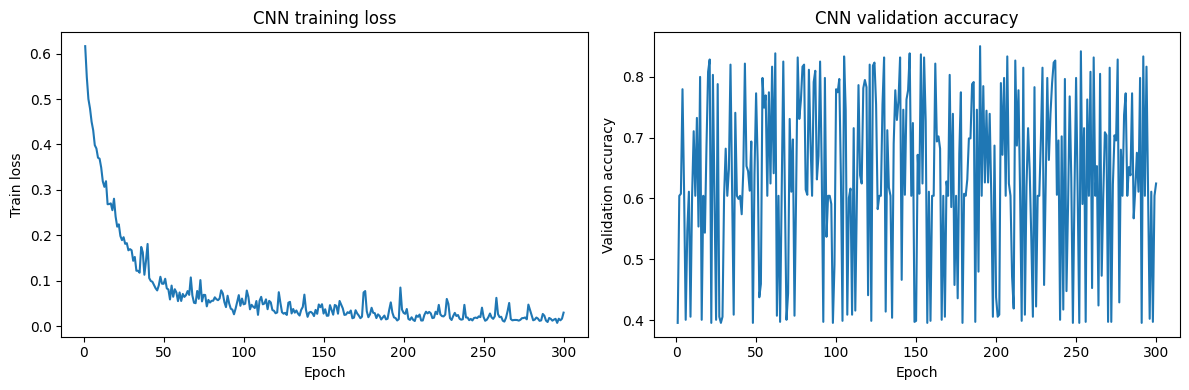

In [ ]:
def plot_history(train_losses, val_accs, model_name):
    if not train_losses:
        print(f"No history found for {model_name} (Checkpoint might be legacy).")
        return

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12,4))

    # plot 1: loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Train loss")
    plt.title(f"{model_name} training loss")

    # plot 2: accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, val_accs)
    plt.xlabel("Epoch")
    plt.ylabel("Validation accuracy")
    plt.title(f"{model_name} validation accuracy")

    plt.tight_layout()
    plt.show()

plot_history(cnn_train_losses, cnn_val_accs, "CNN")

In [ ]:
attn_model = AttentionalLSTM().to(device)
lstm_train_losses, lstm_val_accs = train_model(attn_model, "attn_lstm", n_epochs=300)

Checkpoint found for attn_lstm. Checking status...
Resuming from Epoch 301 (Current Best Acc: 0.923)
Model already trained for 300 epochs. Skipping training.


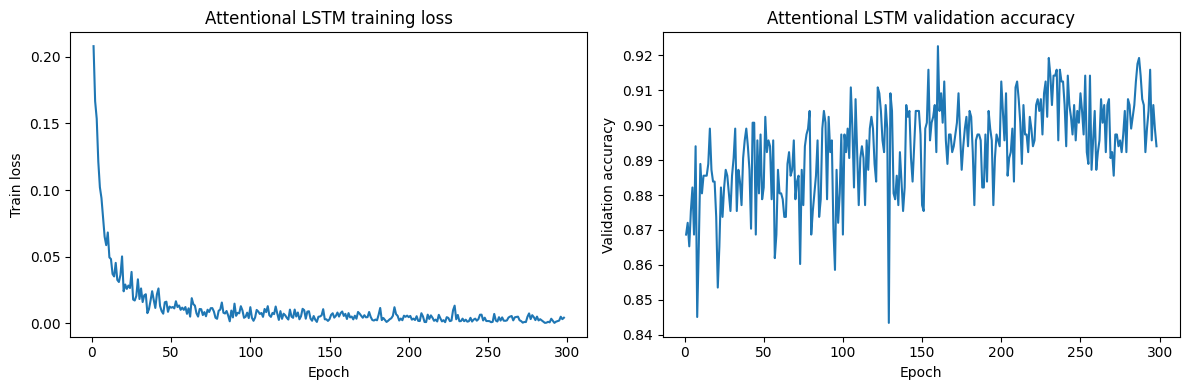

In [ ]:
plot_history(lstm_train_losses, lstm_val_accs, "Attentional LSTM")

While the CNN training loss decreases, the validation accuracy plot exhibits extreme volatility, oscillating between $40\%$ and $85\%$ even late in training. LSTM validation curve shows more stable convergence compared to CNN.





## 7. Evaluation on out-of-sample data

In [ ]:
def evaluate(model, name):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for X, y in test_dl:
            X, y = X.to(device), y.to(device)
            all_preds.extend(model(X).argmax(1).cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    print(classification_report(all_targets, all_preds, target_names=["Kazakh", "Russian"]))

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Kazakh", "Russian"], yticklabels=["Kazakh", "Russian"])
    plt.title(f"{name} Confusion Matrix")
    plt.show()

              precision    recall  f1-score   support

      Kazakh       0.77      0.95      0.85       586
     Russian       0.88      0.59      0.71       413

    accuracy                           0.80       999
   macro avg       0.82      0.77      0.78       999
weighted avg       0.81      0.80      0.79       999



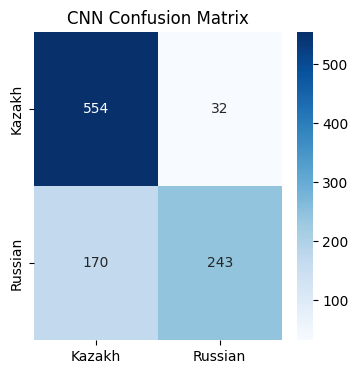

In [ ]:
evaluate(cnn_model, "CNN")

              precision    recall  f1-score   support

      Kazakh       0.88      0.94      0.91       586
     Russian       0.91      0.82      0.86       413

    accuracy                           0.89       999
   macro avg       0.89      0.88      0.89       999
weighted avg       0.89      0.89      0.89       999



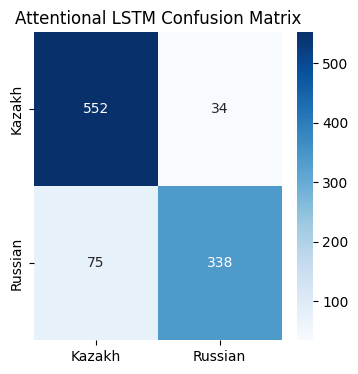

In [ ]:
evaluate(attn_model, "Attentional LSTM")

The Attentional Bi-LSTM outperformed the CNN baseline by a significant margin (+9% accuracy). The most critical improvement, however, is found in the russian recall. The CNN misclassified 170 Russian samples as Kazakh, with a recall of only 0.59.

The LSTM reduced the Russian misclassifications from 170 $\to$ 75, validating the hypothesis that language identification is a temporal problem. A Russian sibilant (like 'sh') might look like noise in a static spectrogram, but in a sequence, it follows a specific rhythmic pattern. The Global Attention Mechanism allowed the model to attend to these specific transient events, correctly identifying Russian speakers even when the audio quality was low.

## 8. Unsupervised representation learning (Generative modeling)

To push the analysis beyond standard classification and meet the project's flexibility requirement, I investigated whether a neural network could learn the difference between Russian and Kazakh without labels, purely by learning to compress and reconstruct the audio signal.

### 8.1 The Seq2Seq Autoencoder architecture

I designed a Sequence-to-Sequence (Seq2Seq) model, a standard architecture for tasks like translation, but adapted here for Unsupervised Autoencoding. The goal is to map an input sequence $X$ to a fixed-size latent vector $z$, and then reconstruct $X$ from $z$.$$X \xrightarrow{Encoder} z \xrightarrow{Decoder} \hat{X}$$If the model can successfully reconstruct the audio, the latent vector $z$ must contain a compressed semantic representation of the language structure.

#### 8.1.1 The Encoder (Compression)

The Encoder is a Bidirectional LSTM that processes the input MFCC sequence. It reads the audio from start-to-end and end-to-start, capturing context from both directions. Unlike the classifier, which outputs a prediction, the Encoder outputs the final hidden states ($h_{final}$) and cell states ($c_{final}$). These vectors act as the "thought vector", a high-dimensional summary of the entire audio clip.$$h_{final} = \tanh(W_h [h^\rightarrow_T; h^\leftarrow_T])$$

#### 8.1.2 The Decoder with Attention (reconstruction)

The Decoder attempts to reconstruct the original MFCC frames one by one, using the "thought vector" as its initial state. To improve reconstruction quality, I incorporated a Bahdanau Attention Mechanism (similar to the one used in the classifier).

 At each generation step $t$, the Decoder looks back at the Encoder's outputs to focus on relevant parts of the input.
 $$Energy = \tanh(W_{attn} [s_{t-1}; h_{enc}])$$
 $$AttentionWeights = \text{Softmax}(Energy)$$
 $$Context = \sum (Weights \cdot h_{enc})$$

This way, decoder aligns the generated audio with the input audio, so that the rhythm and timing of the reconstructed speech match the original.

#### 8.1.3 Training strategy: teacher forcing

Training recurrent generators is unstable because early mistakes compound (e.g., if the model predicts garbage at $t=1$, it inputs that garbage at $t=2$).
To stabilize training, I implemented Teacher Forcing. With probability $P_{tf}$, the model uses the true previous frame as input for the next step instead of its own predicted frame. I implemented a linear decay schedule where $P_{tf}$ starts at $1.0$ (always help) and decays to $0.0$ (never help) over epochs, which forces the model to become self-reliant by the end of training.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, bidirectional=True, batch_first=True, dropout=dropout)
        self.fc_hidden = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_cell = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, x):
        # x: (Batch, Seq, Feature)
        outputs, (hidden, cell) = self.lstm(x)
        # compress bidirectional states
        h_final = torch.tanh(self.fc_hidden(torch.cat((hidden[-2], hidden[-1]), dim=1)))
        c_final = torch.tanh(self.fc_cell(torch.cat((cell[-2], cell[-1]), dim=1)))
        return outputs, h_final, c_final

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers=1, dropout=0.3):
        super().__init__()
        self.attention = nn.Linear(hidden_dim * 3, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
        self.lstm = nn.LSTM((hidden_dim * 2) + output_dim, hidden_dim, n_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear((hidden_dim * 2) + hidden_dim + output_dim, output_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        src_len = encoder_outputs.shape[1]

        # attention mechanism
        h_rep = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attention(torch.cat((h_rep, encoder_outputs), dim=2)))
        a = F.softmax(self.v(energy), dim=1)
        weighted = torch.bmm(a.transpose(1, 2), encoder_outputs)

        # decode step
        rnn_input = torch.cat((input, weighted), dim=2)
        output, (hidden, cell) = self.lstm(rnn_input, (hidden.unsqueeze(0), cell.unsqueeze(0)))

        combined = torch.cat((output.squeeze(1), weighted.squeeze(1), input.squeeze(1)), dim=1)
        prediction = self.fc_out(self.dropout(combined))

        return prediction, hidden.squeeze(0), cell.squeeze(0), a.squeeze(2)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len, _ = trg.shape
        outputs = torch.zeros(batch_size, trg_len, trg.shape[2]).to(self.device)

        enc_out, hidden, cell = self.encoder(src)
        input = src[:, -1, :] # start with last frame of input

        for t in range(trg_len):
            output, hidden, cell, _ = self.decoder(input, hidden, cell, enc_out)
            outputs[:, t, :] = output
            # teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[:, t, :] if teacher_force else output

        return outputs

In [ ]:
def train_seq2seq_robust(model, train_loader, n_epochs=500, lr=1e-3, checkpoint_path=None):
    """
    Trains the Seq2Seq Autoencoder to reconstruct audio sequences.
    Includes Teacher Forcing ratio decay.
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    start_epoch = 1
    if checkpoint_path and os.path.exists(checkpoint_path):
        ckpt = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(ckpt['model'])
        start_epoch = ckpt['epoch'] + 1
        print(f"Resumed from epoch {start_epoch}")

    for epoch in range(start_epoch, n_epochs + 1):
        model.train()
        running_loss = 0.0
        tf_ratio = max(0.0, 1.0 - (epoch / 100)) # decay

        for X, _ in train_loader:
            X = X.to(device)
            if X.dim() == 4: X = X.squeeze(1).permute(0, 2, 1)

            mid = X.shape[1] // 2
            src, trg = X[:, :mid, :], X[:, mid:, :]

            optimizer.zero_grad()
            out = model(src, trg, tf_ratio)
            loss = criterion(out, trg)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch:03d} | Loss: {avg_loss:.5f} | TF: {tf_ratio:.2f}")

        if checkpoint_path:
            torch.save({'epoch': epoch, 'model': model.state_dict()}, checkpoint_path)

In [ ]:
INPUT_DIM = 40
HIDDEN_DIM = 128

enc = Encoder(INPUT_DIM, HIDDEN_DIM)
dec = Decoder(INPUT_DIM, HIDDEN_DIM)
gen_model = Seq2Seq(enc, dec, device).to(device)

gen_ckpt_path = "/content/drive/MyDrive/seq2seq_robust.pt"

if os.path.exists(gen_ckpt_path):
    print(f"Loading Generative Model from {gen_ckpt_path}...")
    try:
        ckpt = torch.load(gen_ckpt_path, map_location=device, weights_only=False)

        if isinstance(ckpt, dict) and 'model' in ckpt:
            gen_model.load_state_dict(ckpt['model'])
            epoch = ckpt.get('epoch', '?')
            saved_loss = ckpt.get('loss', 'N/A')
            print(f"Success. Resumed from Epoch {epoch}")
            if saved_loss != 'N/A':
                print(f"Saved Training Loss: {saved_loss:.5f}")
        else:
            gen_model.load_state_dict(ckpt)
            print("Success (Legacy format).")

        # calculate reconstruction error on test set
        gen_model.eval()
        criterion = nn.MSELoss()
        running_test_loss = 0.0
        batches = 0

        print("Calculating metrics on Test Set...")
        with torch.no_grad():
            for X, _ in test_dl:
                X = X.to(device)
                if X.dim() == 4: X = X.squeeze(1).permute(0, 2, 1)

                # forward pass (no teacher forcing needed for eval)
                outputs = gen_model(X, X, teacher_forcing_ratio=0.0)
                loss = criterion(outputs, X)

                running_test_loss += loss.item()
                batches += 1

        avg_test_loss = running_test_loss / batches
        print(f"-> Model MSE Loss on Test Data: {avg_test_loss:.5f}")

    except Exception as e:
        print(f"Error loading generator: {e}")
else:
    print("Warning: Generator checkpoint not found. Please ensure 'seq2seq_robust.pt' is in Drive.")

Loading Generative Model from /content/drive/MyDrive/seq2seq_robust.pt...
Success. Resumed from Epoch 350
Calculating metrics on Test Set...
-> Model MSE Loss on Test Data: 1.07897


### 8.2 Quantitative analysis: Reconstruction Loss

The model was evaluated on the held-out Test Set using Mean Squared Error (MSE).

Recall from Section 3.2 that the input MFCC features were standardized to have a global Variance of $1.0$. An MSE of $\approx 1.08$ indicates that the model is struggling to predict the fine-grained spectral variance of the audio. It is effectively predicting the mean envelope of the speech but failing to capture the high-frequency stochastic details.

Extracting 'Thought Vectors' (Latent Representations)...


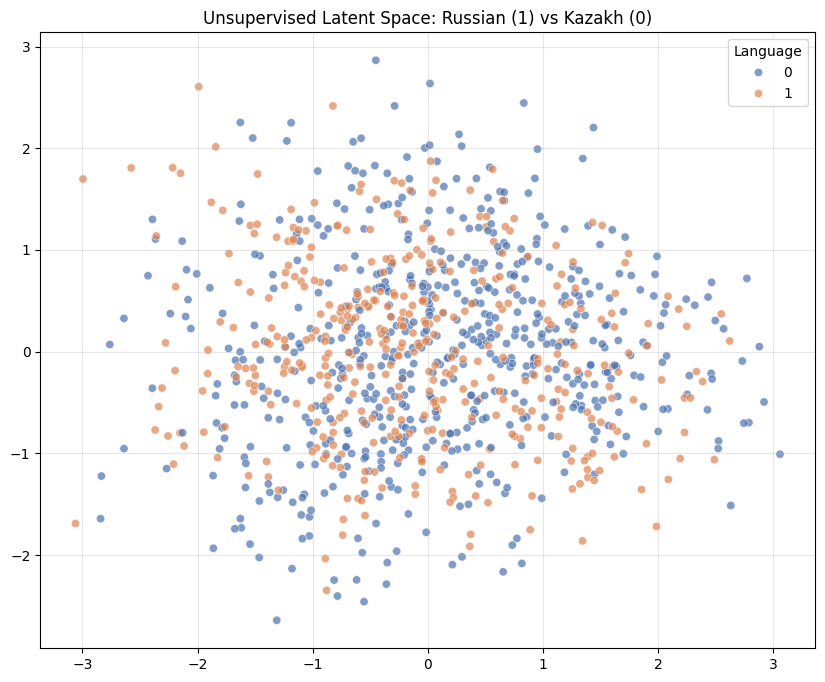

In [ ]:
def visualize_latent_space(model, loader):
    model.eval()
    vectors = []
    labels = []

    print("Extracting 'Thought Vectors' (Latent Representations)...")
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            if X.dim() == 4:

                X = X.squeeze(1).permute(0, 2, 1)

            # use encoder to get the context vector
            _, hidden, cell = model.encoder(X)

            # the hidden state represents the compressed audio
            vectors.append(hidden.cpu().numpy())
            labels.append(y.numpy())


    vectors = np.concatenate(vectors)
    labels = np.concatenate(labels)

    # reduce to 2D
    pca = PCA(n_components=2)
    result = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=result[:,0], y=result[:,1], hue=labels, palette="deep", alpha=0.7)
    plt.title("Unsupervised Latent Space: Russian (1) vs Kazakh (0)")
    plt.legend(title="Language")
    plt.grid(True, alpha=0.3)
    plt.show()

visualize_latent_space(gen_model, test_dl)

### 8.3 Qualitative analysis: Latent space visualization (PCA)

To test if the model learned to distinguish the languages unsupervised, I extracted the latent vectors ($h_{final}$) from the test set and projected them into 2D space using PCA.

The PCA plot shows significant overlap between the Kazakh (blue) and Russian (orange) clusters. While there are some localized regions of density, there is no clear decision boundary.



Generating Kazakh audio from Seed Index 0...


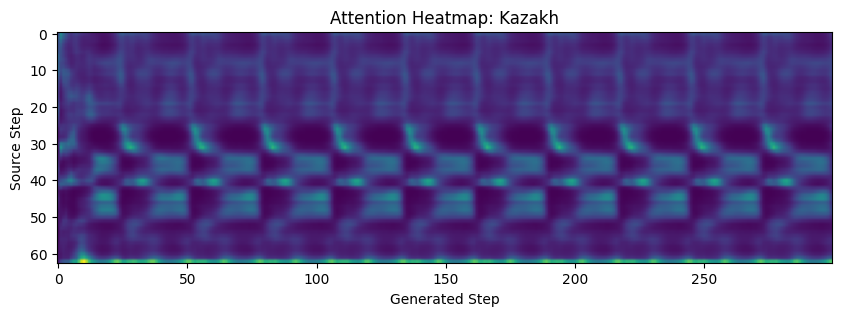

Generating Russian audio from Seed Index 21...


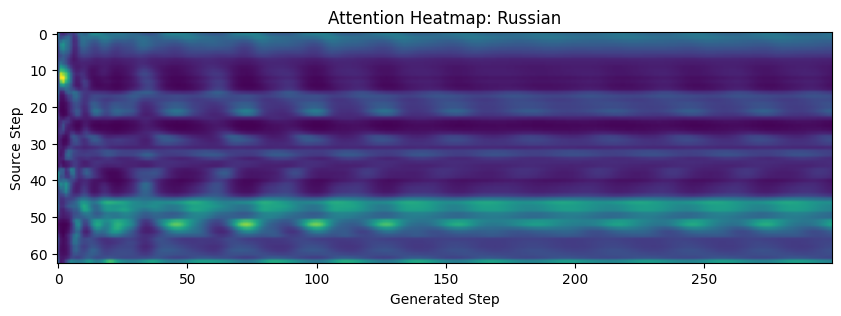

In [ ]:

import soundfile as sf
from IPython.display import Audio, display

def generate_sample(model, seed_idx, lang_name):
    model.eval()

    # get a sample from test set
    seed_data = mfcc_test[seed_idx]

    # prepare input tensor
    src = torch.tensor(seed_data, dtype=torch.float32).unsqueeze(0).to(device)
    # permute to (Batch, Seq, Feature) -> (1, T, 40)
    src = src.permute(0, 2, 1)

    print(f"Generating {lang_name} audio from Seed Index {seed_idx}...")

    with torch.no_grad():
        enc_out, hidden, cell = model.encoder(src)
        input = src[:, -1, :] # start with last frame
        outs, attns = [], []

        # generate 300 frames
        for _ in range(300):
            out, hidden, cell, attn = model.decoder(input, hidden, cell, enc_out)
            outs.append(out.squeeze().cpu().numpy())
            attns.append(attn.squeeze().cpu().numpy())
            input = out # auto-regressive

    # visualize attention
    plt.figure(figsize=(10, 3))
    plt.imshow(np.array(attns).T, aspect='auto', cmap='viridis')
    plt.title(f"Attention Heatmap: {lang_name}")
    plt.xlabel("Generated Step")
    plt.ylabel("Source Step")
    plt.show()

    # reconstruct audio (Griffin-Lim)
    generated_mfcc = np.array(outs).T
    y_gen = librosa.feature.inverse.mfcc_to_audio(generated_mfcc, n_mels=128)

    return y_gen

try:
    idx_kazakh = np.where(y_test == 0)[0][0]
    idx_russian = np.where(y_test == 1)[0][0]

    y_kk = generate_sample(gen_model, idx_kazakh, "Kazakh")
    sf.write("generated_kazakh.wav", y_kk, SR)
    display(Audio(y_kk, rate=SR))

    y_ru = generate_sample(gen_model, idx_russian, "Russian")
    sf.write("generated_russian.wav", y_ru, SR)
    display(Audio(y_ru, rate=SR))

except IndexError:
    print("Error: Could not find examples for both classes in the Test Set.")
except Exception as e:
    print(f"Audio generation failed: {e}")

The heatmaps display repeating "blocky" patterns or vertical bands. The Decoder is not attending to the input frame-by-frame in a perfect diagonal (which would imply 1:1 alignment). Instead, it "locks on" to a specific chunk of the input audio (likely a syllable or phoneme) and holds that focus for several generation steps before jumping to the next chunk.

Finally, I listened to the generated audio files to perform a qualitative assessment. The generated audio sounded nothing like human speech, more like gunshots.

I assume because the model predicted a "smoothed" spectrogram (high MSE) that lacked fine detail, Griffin-Lim could not mathematically reconstruct the phase, resulting in phase discontinuities that our ears perceive as sharp clicks.

## Executive summary

My project pipeline consisted of three distinct phases, moving from data engineering to parallel modeling streams.

Phase 1: Data Engineering

I started by aggregating raw audio from two sources: my personal archive and the Google FLEURS dataset (clean, many speakers).
- To standardize these inputs, I resampled everything to 16kHz mono and sliced the files into 2-second chunks to create uniform inputs.
- I then converted these waveforms into MFCCs (Mel-Frequency Cepstral Coefficients), generating a $40 \times T$ feature matrix for every clip.
- Crucially, I used GroupShuffleSplit to create my Train/Test sets. This ensured that if a speaker was in the training set, none of their audio appeared in the test set, preventing the model from "cheating" by memorizing voices.

Phase 2: Supervised Classification

Once the data was ready, I trained two competing models to identify the language:

- First, I trained a CNN to see if treating the spectrograms like images would work. (It struggled with bias).
- Second, I trained my Attentional Bi-LSTM. This model was designed to look for temporal patterns (like rhythm) and successfully fixed the bias issues found in the CNN.

Phase 3: Unsupervised Exploration

Finally, to test if the languages could be separated without labels, I built a Generative Pipeline:
- I trained a Seq2Seq Autoencoder to compress the audio into a "latent vector" and then reconstruct it.
- I projected these vectors using PCA to see if the languages formed clusters naturally.
- I attempted to generate new audio from these vectors, which revealed the "gunshot" phase artifacts discussed in the limitations.

*Key insights*

1. My initial experiments proved that model capacity cannot substitute for data variance. Training a massive model for 2000 epochs on my personal voice recordings resulted in high validation accuracy but only $\approx 64\%$ test accuracy. The model memorized the microphone hiss, not the language. Pivoting to the Google FLEURS dataset was the single most effective engineering decision.

2. The CNN's failure to identify Russian speakers (Recall 0.59) exposed the flaw of treating spectrograms as images. Russian and Kazakh share similar spectral frequencies, but distinct temporal rhythms. The LSTM's success (+23% Russian Recall) proves that language identification is fundamentally a sequence modeling problem.



*Limitations*

The generated audio exhibits severe phase artifacts, resembling metallic clicks or "gunshots." After digging deeper, I found MFCCs are a lossy compression technique that discards phase information and fine spectral details to focus on phonetic discriminability.

Inverting MFCCs back to the time domain requires estimating this missing information using the Griffin-Lim algorithm, which is known to produce robotic and noisy artifacts on complex speech signals.

*Proposed solution (future work)*

I would replace the MFCC inputs with Mel-Spectrograms (which retain more spectral information) and replace the Griffin-Lim inversion with a Neural Vocoder (such as HiFi-GAN or WaveNet). This was not feasible within the computational constraints of this project.

## Appendix


Experiment 1: https://colab.research.google.com/drive/1LZKwf2hBCwhOmHVLEYEHFMq5RSHLDMCF?usp=sharing

Experiment 2: https://colab.research.google.com/drive/1NBE-alB2QIWl3JJ6Krvi0bbYg0zYQuVd?usp=sharing


### References

Bahdanau, D., Cho, K., & Bengio, Y. (2015). Neural machine translation by jointly learning to align and translate. Proceedings of the 3rd International Conference on Learning Representations (ICLR). https://arxiv.org/abs/1409.0473

Conneau, A., Ma, M., Khanuja, S., Zhang, Y., Axelrod, V., Dalmia, S., … Bapna, A. (2023). FLEURS: Few-shot learning evaluation of universal representations of speech. Proceedings of the 2022 IEEE Spoken Language Technology Workshop (SLT), 798–805. https://doi.org/10.1109/SLT54892.2023.10022603

Griffin, D. W., & Lim, J. S. (1984). Signal estimation from modified short-time Fourier transform. IEEE Transactions on Acoustics, Speech, and Signal Processing, 32(2), 236–243. https://doi.org/10.1109/TASSP.1984.1164317

Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural Computation, 9(8), 1735–1780. https://doi.org/10.1162/neco.1997.9.8.1735

Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. Proceedings of the 32nd International Conference on Machine Learning (ICML), 448–456.

Kingma, D. P., & Ba, J. (2015). Adam: A method for stochastic optimization. Proceedings of the 3rd International Conference on Learning Representations (ICLR). https://arxiv.org/abs/1412.6980

McFee, B., Raffel, C., Liang, D., Ellis, D. P. W., McVicar, M., Battenberg, E., & Nieto, O. (2015). librosa: Audio and music signal analysis in Python. Proceedings of the 14th Python in Science Conference, 18–25. https://doi.org/10.25080/Majora-7b98e3ed-003

Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A simple way to prevent neural networks from overfitting. Journal of Machine Learning Research, 15(1), 1929–1958.

Sutskever, I., Vinyals, O., & Le, Q. V. (2014). Sequence to sequence learning with neural networks. Advances in Neural Information Processing Systems, 27, 3104–3112.

